In [973]:
import pandas as pd, pickle, numpy as np, matplotlib.pyplot as plt, matplotlib.dates as mdates, matplotlib as mpl
import matplotlib.lines as mlines

In [974]:
with open('covid_data.p','rb') as f:
    data = pickle.load(f)

In [975]:
def createMobilityChange(df, cols_to_average, rolling_ave, new_col_name):
    for col in cols_to_average:
        df.loc[:, col] = df[col].astype(float)
    df[new_col_name] = df[cols_to_average].mean(axis=1).rolling(window=7).mean()
    return df

In [976]:
# Create the mobility change column as the average of retail and work spaces
cols_to_average = ['retail_and_recreation_percent_change_from_baseline_goog_cnty',
                   'workplaces_percent_change_from_baseline_goog_cnty']
data = createMobilityChange(data, cols_to_average, 14, 'mobility_change_cnty')

In [977]:
def addFeatures(df):
    df['pop_density'] = df['pop_total'] / df['amount_land']
    df['deaths_per_100k'] = df['deaths_cdc'] / df['pop_total'] * 100000
    df['pir_200_plus_pct'] = df['pir_200_plus'] / df['pir_total']
    df['pir_150_plus_pct'] = (df['pir_150_184'] + df['pir_185_199'] + df['pir_200_plus']) / df['pir_total']
    df['unins_pct'] = (df['unins_0_18'] + df['unins_18_34'] + df['unins_35_64'] + df['unins_65_plus'])/df['unins_total']
    df['hi_75_plus_pct'] = (df['hi_75_99'] + df['hi_100_124'] + df['hi_125_149'] + df['hi_150_199']+ df['hi_200_plus'])/df['hi_total']
    df['hi_100_plus_pct'] = (df['hi_100_124'] + df['hi_125_149'] + df['hi_150_199']+ df['hi_200_plus'])/df['hi_total']
    df['hi_150_plus_pct'] = (df['hi_125_149'] + df['hi_150_199']+ df['hi_200_plus'])/df['hi_total']
    df['e_bach_plus_pct'] = (df['e_bach'] + df['e_mast'] + df['e_prof'] + df['e_doct'])/df['e_total']
    df['e_mast_plus_pct'] = (df['e_mast'] + df['e_prof'] + df['e_doct'])/df['e_total']
    df['r_white_pct'] = df['r_white'] / df['r_total']
    df['r_black_pct'] = df['r_black'] / df['r_total']
    df['r_native_pct'] = df['r_native'] / df['r_total']
    df['r_asian_pct'] = df['r_asian'] / df['r_total']
    return df

In [978]:
def addPercentiles(df, percentile_cols):
    data = df
    data_list = []
    states = list(df.state_code.unique())
    for state in states:
        cols = []
        df = addFeatures(data)
        df = df[df.state_code == state]
        df = df.dropna(subset=['pop_total']).drop_duplicates(subset=['state_code','fips_code']).drop(columns=['date'])
        for percentile_col in percentile_cols:
            df = df.sort_values(by=[percentile_col])
            df['cum_pop_total'] = df['pop_total'].cumsum()
            df[percentile_col + '_percentile'] = df['cum_pop_total'] / df['pop_total'].sum()
        cols = [col + '_percentile' for col in percentile_cols]
        cols = ['state_code','fips_code'] + cols
        df = df[cols]
        data_list.append(df)
    df = pd.concat(data_list)
    data = pd.merge(data, df, how='left', left_on=['state_code','fips_code'], right_on=['state_code','fips_code'])
    return data

In [979]:
# Attach percentile columns
percentile_cols = ['p_c_i', 'pop_density','pir_200_plus_pct', 'pir_150_plus_pct', 'unins_pct',
                  'hi_75_plus_pct', 'hi_100_plus_pct', 'hi_150_plus_pct', 'e_bach_plus_pct', 'e_mast_plus_pct',
                   'r_white_pct','r_black_pct', 'r_native_pct', 'r_asian_pct']
data = addPercentiles(data, percentile_cols)

# Add low and high percentile columns
data['pir_grp'] = [0 if x < 0.5 else 1 for x in data['pir_200_plus_pct_percentile']]
data['unins_grp'] = [0 if x < 0.5 else 1 for x in data['unins_pct_percentile']]
data['pop_density_grp'] = [0 if x < 0.5 else 1 for x in data['pop_density_percentile']] 
data['e_grp'] = [0 if x < 0.5 else 1 for x in data['e_bach_plus_pct_percentile']] 
data['r_b_grp'] = [0 if x < 0.5 else 1 for x in data['r_black_pct_percentile']] 
data['r_w_grp'] = [0 if x < 0.5 else 1 for x in data['r_white_pct_percentile']] 


In [980]:
# Get max death count in each county
def getDeathCounties(df, state, death_col, death_min = 100):
    df = df[df.state_code == state]
    tmp = df.groupby(['fips_code','county_name'])[[death_col]].agg('max').reset_index().sort_values(by='deaths_cdc',ascending=False)
    tmp = tmp[tmp[death_col]>=death_min]
    tmp = tmp.sort_values(by=death_col, ascending=False)
    return list(tmp['fips_code']), list(tmp['county_name'])

In [981]:
def plotCountyDeathCurves(df, state='NY', plot_col = 'deaths_per_100k',
                          death_min_col = 'deaths_cdc', death_min = 100, rolling_ave = 14):
    
    df = df[df.state_code == state]
    df = df[~df.pop_total.isnull()]
    fips_codes, county_names = getDeathCounties(df, state, death_min_col, death_min)
    
    fig = plt.figure(constrained_layout=True, figsize=(15,15))
    gs = fig.add_gridspec(3,2)

    
    
    ### PLOT 1 -------------------
    ## Deaths per 100k by county

    # Set up subplot, axis and titles
    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('Total Deaths (Counties > ' + str(death_min) + ' deaths)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Deaths per 100k')
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    legend_lines = []
    i = 0
    for fips_code, county_name in zip(fips_codes, county_names):
        # Data manipulation
        tmp = df[df.fips_code == fips_code]
        tmp = tmp.groupby(['date'])[plot_col].agg('sum').reset_index()
        # Plot 
        ax1.plot(tmp['date'], tmp[plot_col], color='C'+str(i))
        legend_line = mlines.Line2D([],[], color='C'+str(i), label=county_name)
        legend_lines.append(legend_line)
        i+=1

    # Fix the date labels for both plots
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())

    # Put on the legend
    plt.legend(handles=legend_lines, loc='upper left', title = 'County')
    
    
    
    ### PLOT 2 -------------------
    ## Daily Deaths per 100k by county

    # Set up subplot, axis and titles
    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(str(rolling_ave)+' Day Rolling Average Daily Deaths (Counties > ' + str(death_min) + ' deaths)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Ave Daily Deaths per 100k')
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    legend_lines = []
    i = 0
    for fips_code, county_name in zip(fips_codes, county_names):
        # Data manipulation
        tmp = df[df.fips_code == fips_code]
        tmp = tmp.groupby(['date'])[plot_col].agg('sum').reset_index()
        tmp[plot_col] = tmp[plot_col].diff().rolling(window=rolling_ave).mean()
        # Plot 
        ax1.plot(tmp['date'], tmp[plot_col], color='C'+str(i))
        legend_line = mlines.Line2D([],[], color='C'+str(i), label=county_name)
        legend_lines.append(legend_line)
        i+=1

    # Fix the date labels for both plots
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())

    # Put on the legend
    plt.legend(handles=legend_lines, loc='upper left', title='County')
    
    
    
   ### PLOT 3 -------------------
    ## Deaths per 100k by county

    # Set up subplot, axis and titles
    ax1 = fig.add_subplot(gs[1,0])
    ax1.set_title('Total Deaths by PIR Group (Counties > ' + str(death_min) + ' deaths)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Deaths per 100k')
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    legend_lines = []
    labels = ["Low","High"]
    i = 0
    for i in range(2):
        # Data manipulation
        tmp = df[df['pir_grp']==i]
        tmp = tmp.groupby(['date'])[['pop_total','deaths_cdc']].agg('sum').reset_index()
        tmp[plot_col] = tmp['deaths_cdc'] / tmp['pop_total'] * 100000
        # Plot 
        ax1.plot(tmp['date'], tmp[plot_col], color='C'+str(i))
        legend_line = mlines.Line2D([],[], color='C'+str(i), label=labels[i])
        legend_lines.append(legend_line)
        i+=1

    # Fix the date labels for both plots
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())

    # Put on the legend
    plt.legend(handles=legend_lines, loc='upper left', title='PIR Group')
    
 ### PLOT 4 -------------------
    ## Daily Deaths per 100k by county

    # Set up subplot, axis and titles
    ax1 = fig.add_subplot(gs[1,1])
    ax1.set_title(str(rolling_ave)+' Day Rolling Average Daily Deaths (Counties > ' + str(death_min) + ' deaths)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Deaths per 100k')
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    legend_lines = []
    labels = ["Low","High"]
    i = 0
    for i in range(2):
        # Data manipulation
        tmp = df[df['pir_grp']==i]
        tmp = tmp.groupby(['date'])[['pop_total','deaths_cdc']].agg('sum').reset_index()
        tmp[plot_col] = tmp['deaths_cdc'] / tmp['pop_total'] * 100000
        tmp[plot_col] = tmp[plot_col].diff().rolling(window=rolling_ave).mean()
        # Plot 
        ax1.plot(tmp['date'], tmp[plot_col], color='C'+str(i))
        legend_line = mlines.Line2D([],[], color='C'+str(i), label=labels[i])
        legend_lines.append(legend_line)
        i+=1

    # Fix the date labels for both plots
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())

    # Put on the legend
    plt.legend(handles=legend_lines, loc='upper left', title='PIR Group')
    
    
     ### PLOT 5 -------------------
    ## Deaths per 100k by county

    # Set up subplot, axis and titles
    ax1 = fig.add_subplot(gs[2,0])
    ax1.set_title('Total Deaths by Uninsured Group (Counties >' + str(death_min) + ' deaths)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Deaths per 100k')
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    legend_lines = []
    labels = ["Low","High"]
    i = 0
    for i in range(2):
        # Data manipulation
        tmp = df[df['unins_grp']==i]
        tmp = tmp.groupby(['date'])[['pop_total','deaths_cdc']].agg('sum').reset_index()
        tmp[plot_col] = tmp['deaths_cdc'] / tmp['pop_total'] * 100000
        # Plot 
        ax1.plot(tmp['date'], tmp[plot_col], color='C'+str(i))
        legend_line = mlines.Line2D([],[], color='C'+str(i), label=labels[i])
        legend_lines.append(legend_line)
        i+=1

    # Fix the date labels for both plots
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())

    # Put on the legend
    plt.legend(handles=legend_lines, loc='upper left', title = 'Uninsured Group')
    
 ### PLOT 6 -------------------
    ## Daily Deaths per 100k by county

    # Set up subplot, axis and titles
    ax1 = fig.add_subplot(gs[2,1])
    ax1.set_title(str(rolling_ave)+' Day Rolling Average Daily Deaths by Uninsured Group (Counties > ' + str(death_min) + ' deaths)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Deaths per 100k')
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    legend_lines = []
    labels = ["Low","High"]
    i = 0
    for i in range(2):
        # Data manipulation
        tmp = df[df['unins_grp']==i]
        tmp = tmp.groupby(['date'])[['pop_total','deaths_cdc']].agg('sum').reset_index()
        tmp[plot_col] = tmp['deaths_cdc'] / tmp['pop_total'] * 100000
        tmp[plot_col] = tmp[plot_col].diff().rolling(window=rolling_ave).mean()
        # Plot 
        ax1.plot(tmp['date'], tmp[plot_col], color='C'+str(i))
        legend_line = mlines.Line2D([],[], color='C'+str(i), label=labels[i])
        legend_lines.append(legend_line)
        i+=1

    # Fix the date labels for both plots
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())

    # Put on the legend
    plt.legend(handles=legend_lines, loc='upper left', title = 'Uninsured Group')

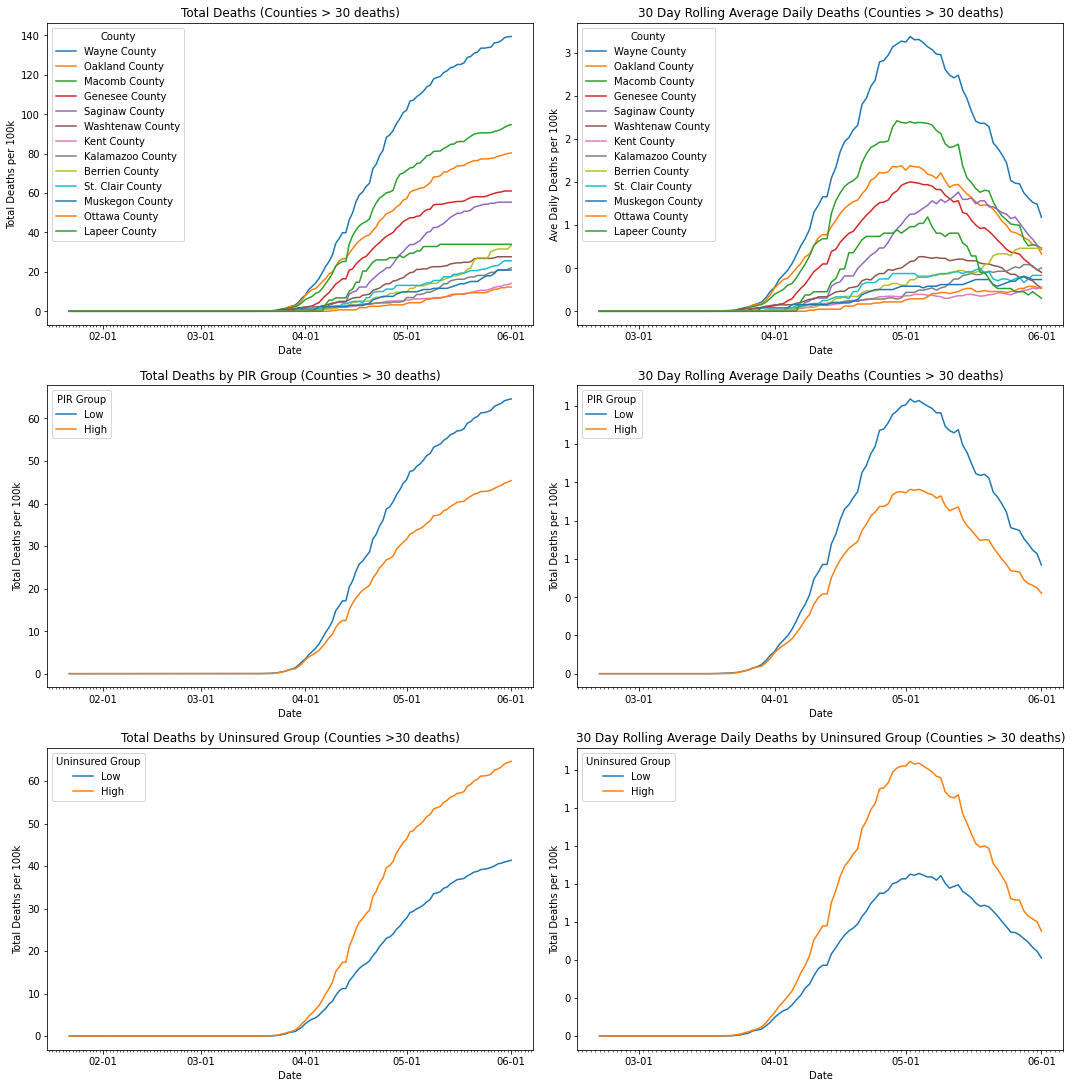

In [982]:
# Need start date end date filter
# Need to fix start times offset due to averages
# Add social distancing (low high split)
# Add population density (low high split, maybe not 50th percentile though?)
# boil it all down to functions, and call each function with a manual state selection and put commentary in a notebook
plotCountyDeathCurves(data, state='MI', 
                      plot_col = 'deaths_per_100k', 
                      death_min_col = 'deaths_cdc', 
                      death_min = 30,
                      rolling_ave = 30)

In [983]:
#df = data[data.state_code == 'MI']
df = data[data.deaths_cdc >= 40].reset_index()
#df = data

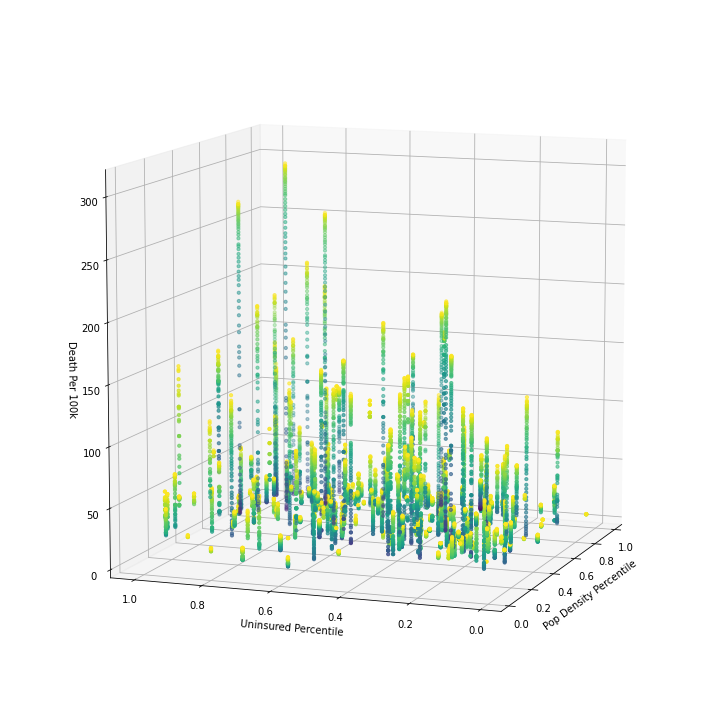

In [984]:
fig = plt.figure(constrained_layout=True, figsize=(10,10))
ax4 = fig.add_subplot(projection='3d')
ax4.set_xlabel('Pop Density Percentile')
ax4.set_ylabel('Uninsured Percentile')
ax4.set_zlabel('Death Per 100k')
ax4.scatter(df['pop_density_percentile'], df['unins_pct_percentile'],df['deaths_per_100k'],c=df['date'], s=10)
ax4.set_zlim(bottom=0)
ax4.view_init(10,20+180)

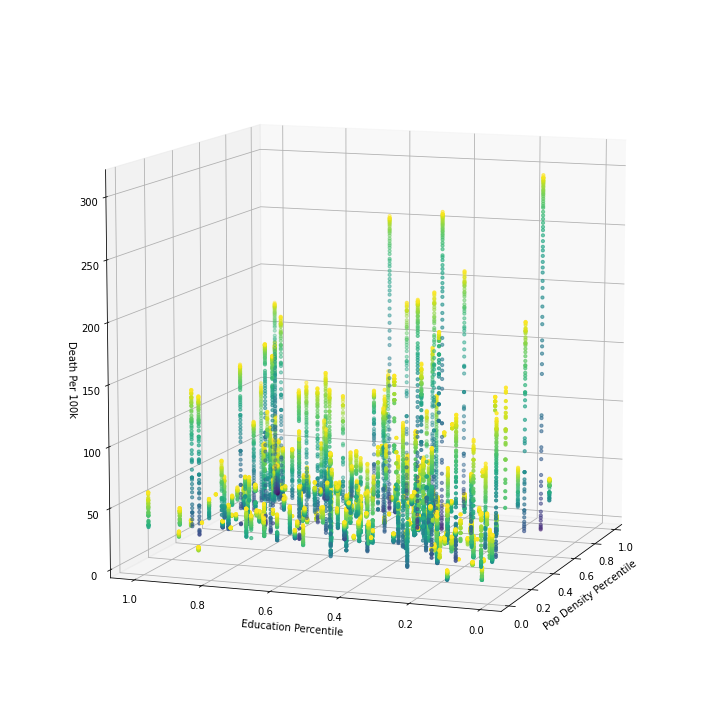

In [985]:
fig = plt.figure(constrained_layout=True, figsize=(10,10))
ax4 = fig.add_subplot(projection='3d')
ax4.set_xlabel('Pop Density Percentile')
ax4.set_ylabel('Education Percentile')
ax4.set_zlabel('Death Per 100k')
ax4.scatter(df['pop_density_percentile'], df['e_bach_plus_pct_percentile'],df['deaths_per_100k'],c=df['date'], s=10)
ax4.set_zlim(bottom=0)
ax4.view_init(10,20+180)

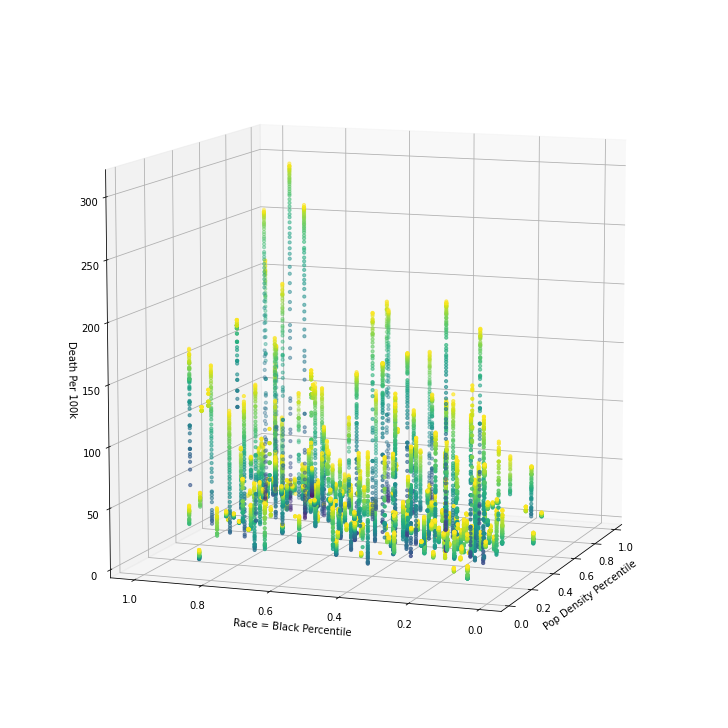

In [986]:
fig = plt.figure(constrained_layout=True, figsize=(10,10))
ax4 = fig.add_subplot(projection='3d')
ax4.set_xlabel('Pop Density Percentile')
ax4.set_ylabel('Race = Black Percentile')
ax4.set_zlabel('Death Per 100k')
ax4.scatter(df['pop_density_percentile'], df['r_black_pct_percentile'],df['deaths_per_100k'],c=df['date'], s=10)
ax4.set_zlim(bottom=0)
ax4.view_init(10,20+180)

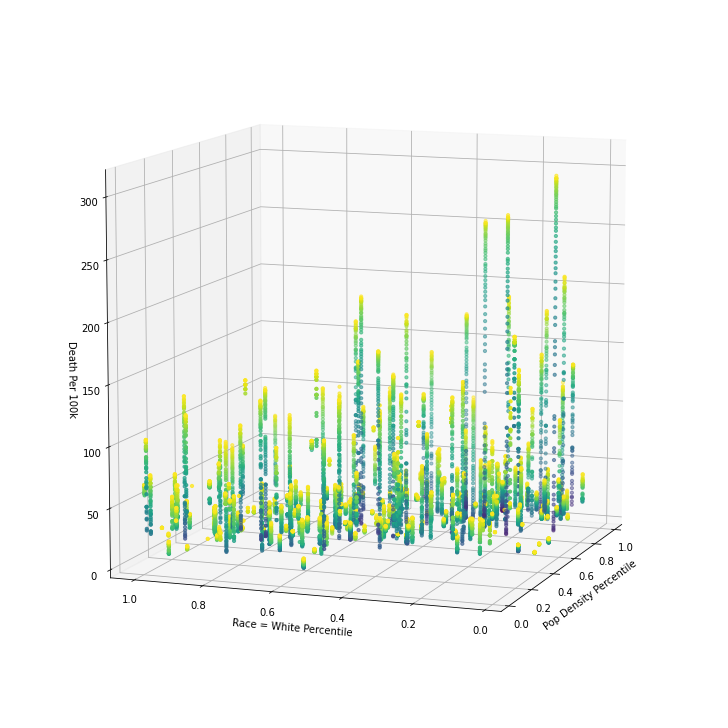

In [987]:
fig = plt.figure(constrained_layout=True, figsize=(10,10))
ax4 = fig.add_subplot(projection='3d')
ax4.set_xlabel('Pop Density Percentile')
ax4.set_ylabel('Race = White Percentile')
ax4.set_zlabel('Death Per 100k')
ax4.scatter(df['pop_density_percentile'], df['r_white_pct_percentile'],df['deaths_per_100k'],c=df['date'], s=10)
ax4.set_zlim(bottom=0)
ax4.view_init(10,20+180)

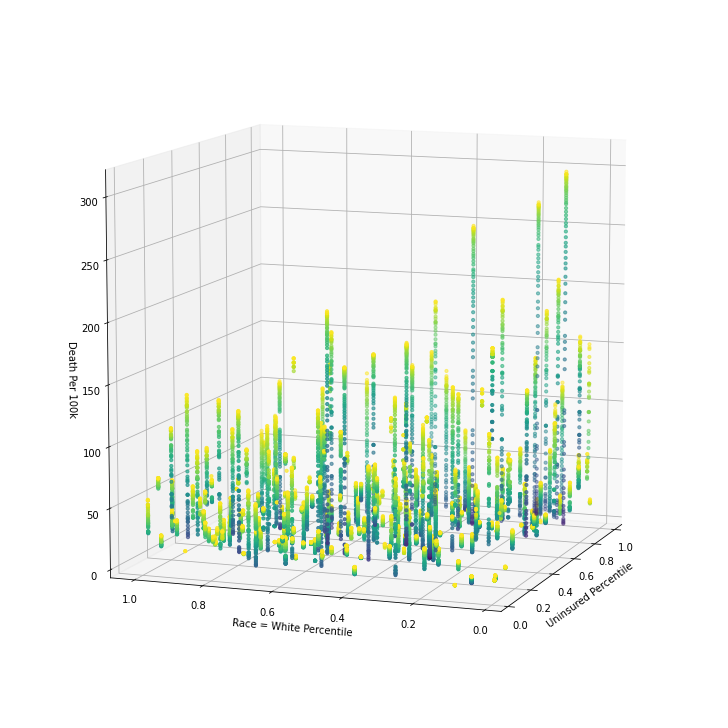

In [988]:
fig = plt.figure(constrained_layout=True, figsize=(10,10))
ax4 = fig.add_subplot(projection='3d')
ax4.set_xlabel('Uninsured Percentile')
ax4.set_ylabel('Race = White Percentile')
ax4.set_zlabel('Death Per 100k')
ax4.scatter(df['unins_pct_percentile'], df['r_white_pct_percentile'],df['deaths_per_100k'],c=df['date'], s=10)
ax4.set_zlim(bottom=0)
ax4.view_init(10,20+180)

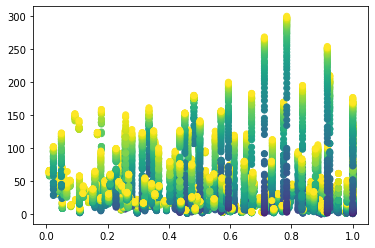

In [989]:
plt.scatter(df['pop_density_percentile'],df['deaths_per_100k'], c=df['date'])

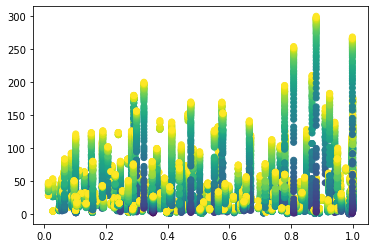

In [990]:
plt.scatter(df['unins_pct_percentile'],df['deaths_per_100k'], c=df['date'])

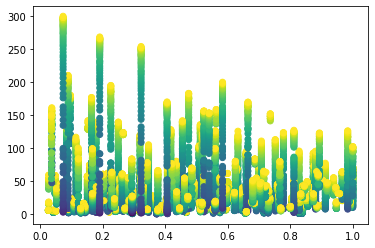

In [991]:
plt.scatter(df['r_white_pct_percentile'],df['deaths_per_100k'], c=df['date'])

In [ ]:
## Data manipulation
# Create Columns
df = data
df['death_per_100k'] = ((df[death_col]/df['pop_total'])*100000) 
df['pop_density'] = (df['pop_total']/df['amount_land'])
col = data[["retail_and_recreation_percent_change_from_baseline_goog_st",
                "workplaces_percent_change_from_baseline_goog_st"]].apply(pd.to_numeric)
df['mobility_change'] = col.mean(axis=1)

# Filter Data
start_date = '2020-03-01'
end_date = '2020-05-16'
df = df[(df.date >= start_date) & (df.date <= end_date)]
#df = df[(df['pop_density'] > 0 ) & (df['pop_density'] > 0) & 
#        (df['death_per_100k'] > 0) & (df['death_per_100k'] > 0) &
#       (df[death_col] > 0)]

fig = plt.figure(constrained_layout=True, figsize=(10,10))
gs = fig.add_gridspec(2,2)

# Create plots
ax1 = fig.add_subplot(gs[0,0])
ax1.set_title('')
ax1.set_xlabel('Pop Density')
ax1.set_ylabel('Death per 100k')
ax1.scatter(df["pop_density"], df['death_per_100k'], c=df['date'], s=10)

ax2 = fig.add_subplot(gs[1,0])
ax2.set_title('')
ax2.set_xlabel('Mobility Change')
ax2.set_ylabel('Death per 100k')
ax2.scatter(-df["mobility_change"], df['death_per_100k'], c=df['pop_density'], s=10, cmap='Greys')

ax3 = fig.add_subplot(gs[0,1])
ax3.set_title('')
ax3.set_xlabel('Pop Density')
ax3.set_ylabel('Mobility Change')
ax3.scatter(df["pop_density"], df['mobility_change'], c=df['date'], s=10)


ax4 = fig.add_subplot(gs[1,1], projection='3d')
ax4.set_title('')
ax4.set_xlabel('Pop Density')
ax4.set_ylabel('Mobility Change')
ax4.set_zlabel('Death Per 100k')
ax4.scatter(df['pop_density'], df['mobility_change'],df['death_per_100k'],c=df['date'], s=10)
ax4.view_init(10,55+180)